In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans

%matplotlib inline

In [21]:
# Read emails dataset
df = pd.read_csv("./data/Emails.csv")
df.head()

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,...,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,...,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,...,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


In [22]:
print(f"Number of Emails: {df.shape[0]}")

Number of Emails: 7945


In [23]:
print(df.loc[1]["ExtractedBodyText"])

B6
Thursday, March 3, 2011 9:45 PM
H: Latest How Syria is aiding Qaddafi and more... Sid
hrc memo syria aiding libya 030311.docx; hrc memo syria aiding libya 030311.docx
March 3, 2011
For: Hillary


### Now our aim is to find which all types of mail we are getting, similar mails can be clubbed into one cluster

In [24]:
# Extracting the text column
df = df[["ExtractedBodyText"]]

In [25]:
# pdf = pd.read_csv("./data/Persons.csv")
# pdf.sample(5)
# Get Sender Person name
# df1 = pd.merge(df, pdf, left_on=["SenderPersonId"], right_on=["Id"], how="left")
# df1
# df1 = df1.drop(["Id_y", "SenderPersonId"], axis=1)
# df1 = df1.rename(columns={"Id_x": "Id", "Name": "SenderName"})
# df1.head()

In [26]:
# Check for null values
df.isnull().sum()

ExtractedBodyText    1203
dtype: int64

#### One step filtering can be done here, if a mail doesn't contain any text we can consider them not important and we can proceed with remaining mails

In [27]:
# df = df.fillna('')
df = df.dropna()
df.head()

,ExtractedBodyText
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest..."
2,Thx
4,"H <hrod17@clintonemail.com>\nFriday, March 11,..."
5,Pis print.\n-•-...-^\nH < hrod17@clintonernail...
7,"H <hrod17@clintonemail.corn>\nFriday, March 11..."


In [28]:
# Adding punctuations too to the stopwords
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

# Getting mail text values
data = df.ExtractedBodyText.values

# Using stemming and tokenization to stem and tokenize each mail
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]


In [29]:
# Now we are using TF-IDF to convert text to vectors
vect = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenize)
X = vect.fit_transform(data)

/home/triloq/anaconda2/envs/mldl/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [30]:
# Get words
word_features = vect.get_feature_names()
print(len(word_features))
print(word_features[5000:5100])

18229
['encompass', 'encount', 'encoura', 'encourag', 'encrypt', 'encumb', 'encycloped', 'encyclopedia', 'encyclopedist', 'end', 'endang', 'endeavor', 'endem', 'ender', 'endgam', 'endless', 'endors', 'endow', 'endstat', 'endur', 'enemi', 'ener', 'energ', 'energet', 'energi', 'enforc', 'eng', 'engag', 'engel', 'engend', 'enghazio', 'engin', 'england', 'englewood', 'english', 'engrav', 'engross', 'engulf', 'enhanc', 'eni', 'enjoy', 'enlai', 'enlarg', 'enlighten', 'enlist', 'enliven', 'enmesh', 'enorm', 'enought', 'enrag', 'enrich', 'enrol', 'enrolle', 'enshrin', 'enshroud', 'ensign', 'enslav', 'ensu', 'ensur', 'ent', 'entail', 'entangl', 'entarpr', 'entebb', 'enter', 'enterpris', 'entertain', 'entftelv', 'enthral', 'enthus', 'enthusiasm', 'enthusiast', 'entic', 'entir', 'entireti', 'entiti', 'entitl', 'entourag', 'entranc', 'entreati', 'entrench', 'entrepreneur', 'entrepreneuri', 'entrepreneurship', 'entri', 'entwin', 'entwistl', 'enuf', 'enumer', 'enunci', 'envelop', 'environ', 'environ

### Now we can use KMeans clustering to create clusters based on mail text

Using Elbow method to get number of clusters

In [31]:
wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = "k-means++", random_state = 7)
    kmeans.fit(X) 
    wcss.append(kmeans.inertia_)

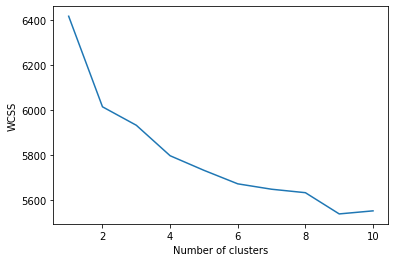

In [32]:
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

As more than one elbows have been generated, We will have to select right amount of clusters by trial and error.


In [33]:
# One option for cluster can be 4 and other can be 6, 9
# Let's use 4
kmeans = KMeans(n_clusters = 4, init = "k-means++", random_state = 7)
y_kmeans = kmeans.fit_predict(X)

In [34]:
df['cluster'] = pd.Series(y_kmeans, index=df.index)
df

,ExtractedBodyText,cluster
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",1
2,Thx,1
4,"H <hrod17@clintonemail.com>\nFriday, March 11,...",3
5,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,3
7,"H <hrod17@clintonemail.corn>\nFriday, March 11...",3
...,...,...
7938,"Hi. Sorry I haven't had a chance to see you, b...",1
7939,"B6\nI assume you saw this by now -- if not, it...",1
7941,Big change of plans in the Senate. Senator Rei...,1
7943,"PVerveer B6\nFriday, December 17, 2010 12:12 A...",1


In [35]:
# We look at 4 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(word_features[word] for word in centroid))

0 : ok, thx, w, pls, talk, sound, dc, op, good, work, gheit, ill, they'r, gone, certain, minut, tonight, connect, asap, lavrov, set, follow, befor, shuttl, safe
1 : b, yes, print, pls, work, talk, thx, know, just, want, w, tomorrow, i'm, thank, u, time, today, let, good, need, email, think, state, like, come
2 : fyi, b, articl, minut, post, c, said, discuss, good, know, just, frosti, frontlin, frontrunn, frost, frugal, frsorn, fruitless, frontier, frown, fruition, frozen, fruit, froup, zziti
3 : pm, gov, state, h, fw, cheryl, millscd, d, clintonemail, hrod, com, abedin, huma, b, abedinh, sullivan, sunday, j, secretari, wednesday, jacob, saturday, offic, sullivanjj, thursday


### Now we can check study each cluster to see which contains words which are not so important.
For eg: Cluster 3 seems to be important as top words are gov, state, etc.